In [1]:
#imports
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of
    

def taglia_e_cuci(v):
    hi=np.quantile(v,0.005)
    lo=np.quantile(v, 0.995)
    b=np.clip(v, hi,lo)
    z=stats.zscore(v)#normalizer.fit_transform((b.values.reshape(-1,1))).flatten().tolist()
    return b


def baSpread(x):
    a=x['AP1'].values.tolist()
    b=x['BP1'].values.tolist()
    bas=np.empty(len(x))
    for i in range(len(a)):
       bas[i]=(a[i]-b[i])/(a[i]+b[i])*10**4
    return bas

In [3]:
#load data e fa midprice/diff cum
lob_data=pd.read_csv('/Users/macri/Desktop/out_1.csv') #out_1  PROJECT/out_Nuovo
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['index'], axis=1,inplace=True)#Unnamed: 0 
C= int(len(lob_data)*0.05)
b=lob_data.iloc[ :C].copy()
ld=b.values.tolist()
lob_data=b
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)

bas=pd.DataFrame(baSpread(lob_data),columns=['bas'])
bas['diff']=bas.diff()
of_data.dropna(inplace=True)


In [4]:
bas.dropna(inplace=True)

In [5]:
bas.reset_index(inplace=True)

In [6]:
ba=bas['diff'].to_numpy()
lo=np.quantile(ba, 0.005)
hi=np.quantile(ba, 0.995)



vec = np.zeros(len(of_data))
for i in range(len(bas)-1):
    if (bas.loc[i+1,'diff']) > hi*(bas.loc[i,'diff']):
        vec[i] = 1
    elif  (bas.loc[i+1,'diff']) < lo*(bas.loc[i,'diff']):
        vec[i] = -1
vec

array([0., 0., 0., ..., 1., 0., 0.])

In [7]:
#train_weight=0.8
#vali_weight=0.1
#
#
#train=of_data.iloc[:int(len(of_data)*train_weight)]
#validation=of_data.iloc[int(len(of_data)*train_weight):int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)]
#test=of_data.iloc[int(len(of_data)*train_weight)+int(len(of_data)*vali_weight):]
#n_train=taglia_e_cuci(train)
#n_vali =taglia_e_cuci(validation)
#n_test =taglia_e_cuci(test)
#
#for col in train.columns:#'aOF_1',	'bOF_1',	'aOF_2',	'bOF_2',	'aOF_3',	'bOF_3']:
#    mu = 0#float(train.loc[:,col].mean())
#    sigma = float(train.loc[:,col].std())
#    stdize_input = lambda x: (x - mu) / sigma
#
#std_train=n_train.apply(stdize_input)
#std_vali =n_vali .apply(stdize_input)
#std_test =n_test .apply(stdize_input)
#
#std_train['spread']=vec[:int(len(of_data)*train_weight)]
#std_vali ['spread']=vec[int(len(of_data)*train_weight):int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)]
#std_test ['spread']=vec[int(len(of_data)*train_weight)+int(len(of_data)*vali_weight):]
#
#
#
#std_train.head(),std_vali .head(),std_test .head()

In [8]:
#of_data.apply(lambda x: (x-x.mean())/x.std())

In [9]:
# define method to format the data
#def format_data(data, lag, dimension):
#    '''
#    lag: the order of the VAR process, or the lookback window in the sequential model
#    dimension: number of variables in the time series
#    '''
#    data = data.values
#    shape = data.shape
#    X = np.zeros((shape[0]-lag, lag, dimension))
#    Y = np.zeros((shape[0]-lag, 1)) # 1 for the number of forecasting horizons
#    for i in range(shape[0]-lag):
#        X[i] = data[i:i+lag, :dimension] 
#        Y[i] = data[i+lag-1, -1:] 
#    X = X.reshape(X.shape[0], lag, dimension, 1)
#    
#    Y += 1 # relabel as 0, 1, 2
#    
#    Y = np_utils.to_categorical(Y.astype(int))
#    
#    return X,Y

In [10]:
#trainX, trainY = format_data(std_train, 100, len(std_train.columns)-1)
#valiX, valiY   = format_data(std_vali,  100,  len(std_vali.columns)-1)
#testX, testY   = format_data(std_test,  100,  len(std_test.columns)-1)
#print(trainX.shape, trainY.shape)
#print(valiX.shape, valiY.shape )
#print(testX.shape, testY.shape )


In [11]:
def prepare_x(data):
    df1 = data[:, :6]
    return np.array(df1)

def get_label(data):
    lob = data[:, -1:]
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(-1,100,6,1), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    #y = y[:,k]
    y = np_utils.to_categorical(y, 3)
    return x, y

In [12]:
train_weight=0.9
vali_weight=0.05


train=of_data.iloc[:int(len(of_data)*train_weight)]
validation=of_data.iloc[int(len(of_data)*train_weight):int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)]
test=of_data.iloc[int(len(of_data)*train_weight)+int(len(of_data)*vali_weight):]
n_train=taglia_e_cuci(train)
n_vali =taglia_e_cuci(validation)
n_test =taglia_e_cuci(test)

for col in train.columns:#'aOF_1',	'bOF_1',	'aOF_2',	'bOF_2',	'aOF_3',	'bOF_3']:
    mu = float(train.loc[:,col].mean())
    sigma = float(train.loc[:,col].std())
    stdize_input = lambda x: (x - mu) / sigma

std_train=n_train.apply(stdize_input)
std_vali =n_vali .apply(stdize_input)
std_test =n_test .apply(stdize_input)

std_train['spread']=vec[:int(len(of_data)*train_weight)]
std_vali ['spread']=vec[int(len(of_data)*train_weight):int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)]
std_test ['spread']=vec[int(len(of_data)*train_weight)+int(len(of_data)*vali_weight):]



std_train.head(),std_vali .head(),std_test .head()

(      aOF_1    bOF_1    aOF_2    bOF_2    aOF_3    bOF_3  spread
 0 -0.406798  0.05394  0.05394  0.05394  0.05394  0.05394     0.0
 1  0.053940  0.05394  0.05394  0.05394  0.05394  0.05394     0.0
 2  0.053940  0.05394  0.05394  0.05394  0.05394  0.05394     0.0
 3  0.053940  0.05394  0.05394  0.05394  0.05394  0.05394     0.0
 4 -0.094207  0.05394  0.05394  0.05394  0.05394  0.05394     0.0,
           aOF_1     bOF_1     aOF_2     bOF_2    aOF_3     bOF_3  spread
 47185  0.053940 -0.094207 -0.094207  0.053940  0.05394  0.053940     1.0
 47186  0.053940 -1.023090  1.130970 -0.874943  0.05394 -1.131237     0.0
 47187  0.686528 -0.766795 -0.766795 -0.242355  1.13097 -0.094207     1.0
 47188  0.471715 -0.094207 -0.094207  0.053940  0.05394  0.053940     1.0
 47189 -0.107541 -0.578649  0.686528 -0.983090  0.05394 -1.731233     0.0,
           aOF_1     bOF_1     aOF_2     bOF_2     aOF_3     bOF_3  spread
 49806  0.053940 -0.405316  0.513196 -0.390502  0.053940 -1.279385     0.0
 49807  

In [13]:
trainX, trainY = prepare_x_y(std_train.to_numpy(), 1   ,  100)
valiX, valiY   = prepare_x_y(std_vali .to_numpy(), 1   ,  100)
testX, testY   = prepare_x_y(std_test .to_numpy(), 1   ,  100)
print(trainX.shape, trainY.shape)
print(valiX.shape, valiY.shape )
print(testX.shape, testY.shape )


(47086, 100, 6, 1) (47086, 3)
(2522, 100, 6, 1) (2522, 3)
(2523, 100, 6, 1) (2523, 3)


In [14]:

def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])#

    return model

deeplob = create_nn(100, 6, 64)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [15]:

#early stopping: pazienza=5 e check val_loss
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)


In [16]:
simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY), 
            epochs=50, batch_size=250,  callbacks=[callback])#

Epoch 1/50
189/189 [==============================] - 43s 217ms/step - loss: 0.9838 - accuracy: 0.5093 - val_loss: 0.9456 - val_accuracy: 0.5135
Epoch 2/50
189/189 [==============================] - 42s 222ms/step - loss: 0.9045 - accuracy: 0.5694 - val_loss: 0.8363 - val_accuracy: 0.6487
Epoch 3/50
189/189 [==============================] - 42s 222ms/step - loss: 0.8256 - accuracy: 0.6473 - val_loss: 0.8176 - val_accuracy: 0.6435
Epoch 4/50
189/189 [==============================] - 43s 226ms/step - loss: 0.8168 - accuracy: 0.6489 - val_loss: 0.8085 - val_accuracy: 0.6542
Epoch 5/50
189/189 [==============================] - 43s 227ms/step - loss: 0.8107 - accuracy: 0.6509 - val_loss: 0.7995 - val_accuracy: 0.6542
Epoch 6/50
189/189 [==============================] - 46s 244ms/step - loss: 0.8055 - accuracy: 0.6522 - val_loss: 0.7974 - val_accuracy: 0.6550
Epoch 7/50
189/189 [==============================] - 56s 297ms/step - loss: 0.8013 - accuracy: 0.6532 - val_loss: 0.7890 - val_ac

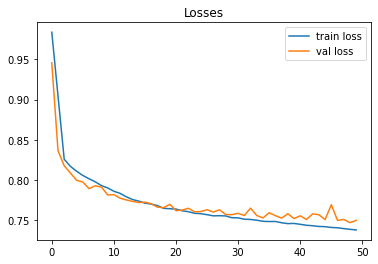

In [17]:
#plotta le loss
plt.plot(simple.history['loss'], label='train loss')
plt.plot(simple.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses');

In [18]:
pred = deeplob.predict(testX)

79/79 [==============================] - 2s 20ms/step


In [22]:
pred

array([[0.80234015, 0.02540486, 0.17225508],
       [0.03037884, 0.75845295, 0.21116823],
       [0.31248793, 0.5472824 , 0.14022964],
       ...,
       [0.28254262, 0.493271  , 0.2241864 ],
       [0.676809  , 0.18047965, 0.14271128],
       [0.7049633 , 0.10571222, 0.18932448]], dtype=float32)

In [25]:
predictions=np.round(pred)

In [28]:
print('accuracy_score:', accuracy_score(np.argmax(testY, axis=1), np.argmax(predictions, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(predictions, axis=1), digits=4))

accuracy_score: 0.6682520808561236
              precision    recall  f1-score   support

           0     0.6698    0.8961    0.7666      1347
           1     0.6690    0.5164    0.5829       912
           2     0.4706    0.0303    0.0569       264

    accuracy                         0.6683      2523
   macro avg     0.6031    0.4809    0.4688      2523
weighted avg     0.6487    0.6683    0.6259      2523



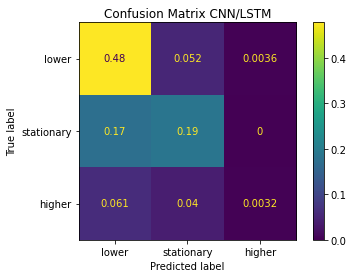

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1),normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['lower','stationary','higher'])
disp.plot()
disp.ax_.set_title("Confusion Matrix CNN/LSTM");